In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
## A deserialiser function to extract the fields of interest.
## Not all of this data was used to create a visualisation, but all of it was explored.
## Timestamp was discarded as all measurements were within three minutes of one another.

def deserialise_line(record):
    return (record["city"]["findname"], record["city"]["coord"]["lon"], record["city"]["coord"]["lat"], record["main"]["pressure"], record["main"]["humidity"],record["main"]["temp_min"], record["main"]["temp_max"], record["wind"]["speed"], record["clouds"]["all"], [entry["main"] for entry in record["weather"]])

In [3]:
## Read and deserialise the json lines one-by-one.

data = []
with open("./weather.json", encoding="utf8") as f:
    for line in f:
        json_line = json.loads(line)
        data.append(deserialise_line(json_line))

In [4]:
## Units were inferred from data exploration, as seen below.

df = pd.DataFrame(data, columns=["city_name", "lon", "lat", "pressure(mb)", "humidity(%)", "temp_min(K)", "temp_max(K)", "wind_speed(m/s)", "cloud_cover(%)", "weather"])

In [5]:
print("Average wind speed = " + str(np.mean(df["wind_speed(m/s)"]))) 
# Global average land wind speed is ~3.3m/s. Can infer m/s are the units.
print("Maximum temperature = " + str(np.max(df["temp_max(K)"])))
# These temperature units are certainly given in Kelvin

Average wind speed = 3.502612904918909
Maximum temperature = 318.15


In [6]:
df.head()

,city_name,lon,lat,pressure(mb),humidity(%),temp_min(K),temp_max(K),wind_speed(m/s),cloud_cover(%),weather
0,AZADSHAHR,48.570728,34.790878,1022.00,71,284.150,289.150,4.10,90,[Clouds]
1,JILIB,42.785351,0.488290,1008.39,36,309.929,309.929,5.72,0,[Clear]
2,KISMAAYO,42.545361,-0.358170,1009.87,100,301.329,301.329,6.12,0,[Clear]
3,EYL,49.816399,7.980300,1010.67,80,302.229,302.229,5.02,0,[Clear]
4,KAHRIZ,47.055302,34.383801,1021.00,66,285.150,286.150,2.10,75,[Clouds]


In [7]:
## Check to see which values occur in the "weather" entities.

from itertools import chain
from collections import Counter
array = df["weather"]
print(Counter(chain(*array)))

Counter({'Clouds': 94686, 'Clear': 57649, 'Rain': 36938, 'Mist': 21565, 'Drizzle': 4888, 'Fog': 2980, 'Haze': 1400, 'Snow': 1262, 'Thunderstorm': 955, 'Smoke': 63, 'Dust': 16, 'Sand': 3})


In [8]:
## Create a score of the severity for the weather conditions.
## The selection below is exhausitive.

weather_severity = {
 'Haze': 0, 
 'Sand': 2, 
 'Drizzle': 1, 
 'Clouds': 0, 
 'Dust': 1, 
 'Smoke': 1,
 'Mist': 0, 
 'Fog': 3, 
 'Clear': 0, 
 'Thunderstorm': 4,
 'Rain': 2, 
 'Snow': 4
}

def score_weather(weather):  # takes list
    weather_scores = []
    for record in weather:
        weather_scores.append(weather_severity[record])
    return max(weather_scores)

df["weather_score"] = [score_weather(i) for i in df["weather"]]

C:\Users\john.blake\AppData\Local\Continuum\anaconda3\envs\white_swan_data_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


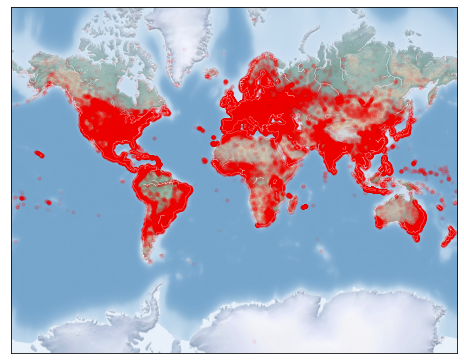

In [9]:
## This is a heatmap of weather stations locations

# inspired by: https://stackoverflow.com/questions/46620984/how-to-draw-scatter-plot-on-top-of-background-using-basemap-python
# n.b. the dedent function from matplotlib, called implicitly below, is deprecated

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', 
            llcrnrlat=-80, urcrnrlat=80, 
            llcrnrlon=-180, urcrnrlon=180, 
            lat_ts=20, 
            resolution='c')

m.shadedrelief(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(df["lon"].tolist(), df["lat"].tolist())  # transform coordinates
plt.scatter(x, y, 10, marker='o', color='r', alpha=0.05) 

plt.show()

C:\Users\john.blake\AppData\Local\Continuum\anaconda3\envs\white_swan_data_env\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


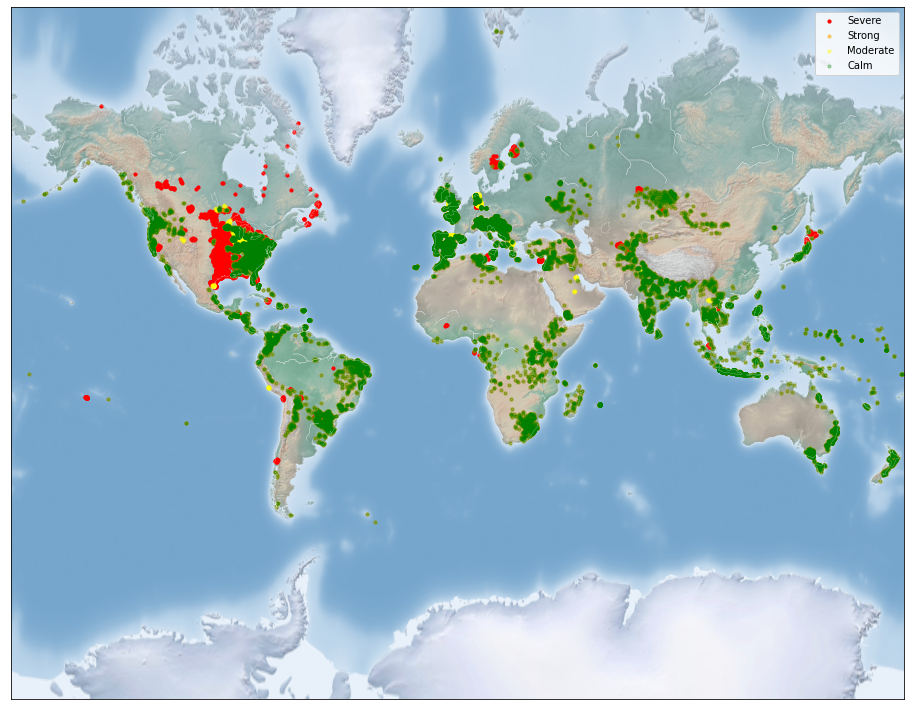

In [10]:
## This plots a heatmap of weather stations coloured by the severity of reported weather.

# inspired by: https://stackoverflow.com/questions/46620984/how-to-draw-scatter-plot-on-top-of-background-using-basemap-python
# n.b. the dedent function from matplotlib, called implicitly below, is deprecated

fig = plt.gcf()
fig.set_size_inches(16, 13)

m = Basemap(projection='merc', 
            llcrnrlat=-80, urcrnrlat=80, 
            llcrnrlon=-180, urcrnrlon=180, 
            lat_ts=20, 
            resolution='c')

m.shadedrelief(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x_red, y_red = m(df[df["weather_score"] >= 3]["lon"].tolist(), df[df["weather_score"] >= 3]["lat"].tolist())  # transform coordinates
plt.scatter(x_red, y_red, 10, marker='o', color='r', alpha=1, label="Severe")
x_orange, y_orange = m(df[df["weather_score"] == 2]["lon"].tolist(), df[df["weather_score"] == 2]["lat"].tolist())  # transform coordinates
plt.scatter(x_orange, y_orange, 10, marker='o', color='orange', alpha=0.5, label="Strong")
x_yellow, y_yellow = m(df[df["weather_score"]==1]["lon"].tolist(), df[df["weather_score"] == 1]["lat"].tolist())  # transform coordinates
plt.scatter(x_yellow, y_yellow, 10, marker='o', color='yellow', alpha=0.4, label="Moderate")
x_green, y_green = m(df[df["weather_score"] == 0]["lon"].tolist(), df[df["weather_score"] == 0]["lat"].tolist())  # transform coordinates
plt.scatter(x_orange, y_orange, 10, marker='o', color='green', alpha=0.3, label="Calm")

plt.legend()

plt.show()